### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2023 Semester 2

## Assignment 1

**Student Name:**    Arya Araban

**Student ID:**     1439683

This iPython notebook is a template which you should use for your Assignment 1 submission. This file should be submitted at the **Assignment 1** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a written report explaining your results at the **Assignment 1** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

In [27]:
# I created this notebook in a Google Colab Enviornment
# Make sure to place the assets directory in the root path.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


In [3]:
def plt_imshow(ax, img, title=None, cmap='gray', vmin=0, vmax=255): # Created this Function for a more convienent image showing
    ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.axis('off')
    if title:
      ax.set_title(title)

### 0. Laplacian pyramid compression
You can use the code below to check how much a quantized Laplacian pyramid representation compresses an image.

In [4]:
imSize = 256 # image height/width (assume image is square)
bitsPerLevel = [1,2,3,4,8] # bits used to encode each level of pyramid

# Image size before compression, in bits (assume uint8 grayscale)
sizeUncompressed = 8 * imSize * imSize
print('Uncompressed size = '+str(sizeUncompressed)+' bits')

# Image size after compression, in bits
sizeCompressed = 0
for i in range(len(bitsPerLevel)):
    sizeCompressed = sizeCompressed + (bitsPerLevel[i]*(imSize/(pow(2,i)))*(imSize/(pow(2,i))))
print('Compressed size = '+str(sizeCompressed)+' bits')

print(str(round(100*sizeCompressed/sizeUncompressed))+'% of original')

Uncompressed size = 524288 bits
Compressed size = 116736.0 bits
22% of original


### 1. Laplacian image pyramid

In [5]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
# Define the filter kernel
kernel = (1/256)*np.array([[1, 4, 6, 4, 1],
                           [4, 16, 24, 16, 4],
                           [6, 24, 36, 24, 6],
                           [4, 16, 24, 16, 4],
                           [1, 4, 6, 4, 1]])


def build_laplacian_pyramid(image, levels):
    '''input: image(np.ndarray), levels(int) -- output: pyramid(list)'''

    pyramid = []
    for i in range(levels):
        if i < levels - 1:
            # Filter the image with the Gaussian kernel
            filtered_image = cv2.filter2D(image,-1,kernel)
            # Downsample
            downsampled_image = filtered_image[::2, ::2]

            # Upsample the downsampled image by injecting zeros into every other row/column
            upsampled_image = np.zeros_like(image)
            upsampled_image[::2, ::2] = downsampled_image

            # Filter the upsampled image with the kernel 4 * g
            filtered_upsampled_image = cv2.filter2D(upsampled_image,-1,kernel*4)

            # Compute error by subtracting the filtered upsampled image from the original image
            error = image - filtered_upsampled_image

            # Shift the pixel values of the error image by adding 128 to them
            error += 128
            pyramid.append(error)

            # Set the downsampled image as the new image for the next iteration
            image = downsampled_image
        else:
            pyramid.append(image)
    return pyramid


def reconstruct_from_laplacian_pyramid(pyramid):
  '''input: pyramid(list) -- output: reconstructed_image(np.ndarray)'''

  reconstructed = pyramid[-1].astype(np.float32) # last layer

  for i in range(len(pyramid)-2, -1, -1): # iterate from second last layer to the first later

    # Upsample - inject zeros
    up = np.zeros((reconstructed.shape[0]*2, reconstructed.shape[1]*2)).astype(np.float32)
    up[::2, ::2] = reconstructed

    # Filter
    up_filtered = cv2.filter2D(up, -1, 4*kernel, borderType=cv2.BORDER_DEFAULT)

    # Add Laplacian
    lap = pyramid[i].astype(np.float32) - 128
    reconstructed = up_filtered + lap

  # Clip and convert to uint8
  reconstructed = np.clip(reconstructed, 0, 255).astype(np.uint8)

  return reconstructed


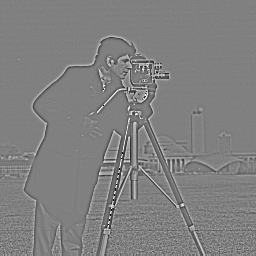

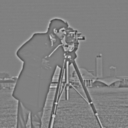

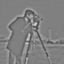

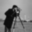

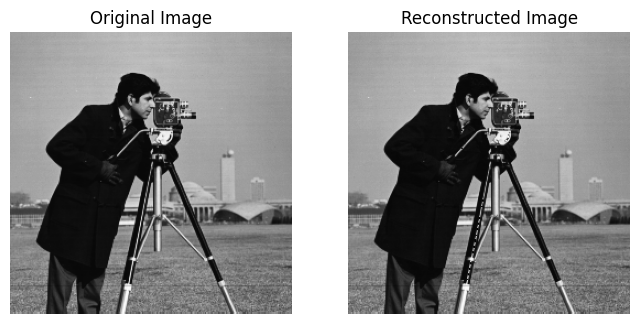

In [7]:
# Load image
image = cv2.imread('assets/cameraman.png', cv2.IMREAD_GRAYSCALE)

# Build a Laplacian pyramid from the input grayscale image with a specified number of levels
levels = 4
pyramid = build_laplacian_pyramid(image, levels)

# Display each level of the Laplacian pyramid
for i in range(levels):
    cv2_imshow(pyramid[i]) # cv2.imshow(f"level {i}", pyramid[i]) if running locally -- or plt

# Reconstruct an image from its Laplacian pyramid

reconstructed_image = reconstruct_from_laplacian_pyramid(pyramid)


# Display the original and reconstructed images side by side for comparison
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))

plt_imshow(axs[0], image, title = 'Original Image')
plt_imshow(axs[1], reconstructed_image, title='Reconstructed Image')


### 2. Quantization and compression

Quantization

In [28]:
def quantize_image(image, b):
    '''
    input: image(np.ndarray), b(int) -- output: quantized_image(np.ndarray)
    '''
    # Compute the number of bins
    bins = 2**b

    # Flatten the image
    flat_image = image.flatten()

    # Compute the bin edges using numpy's percentile function
    percentiles = np.linspace(0, 100, bins+1)
    bin_edges = np.percentile(flat_image, percentiles)

    # Compute the bin indices for each pixel in the image
    bin_indices = np.digitize(flat_image, bin_edges) - 1

    # Clip bin_indices to be within [0, bins-1]
    bin_indices = np.clip(bin_indices, 0, bins-1)

    # print("Pixels per bin:") #TEST
    # for i in range(bins):
    #   print(f"Bin {i}: {np.count_nonzero(bin_indices==i)}")

    # Compute the mean pixel value in each bin
    bin_means = np.array([flat_image[bin_indices == i].mean() for i in range(bins)])

    # Replace all pixels within a given bin with the mean pixel value in that bin
    quantized_image = bin_means[bin_indices]

    # Reshape the quantized image to have the same shape as the input image
    quantized_image = quantized_image.reshape(image.shape)

    return quantized_image.astype(np.uint8)

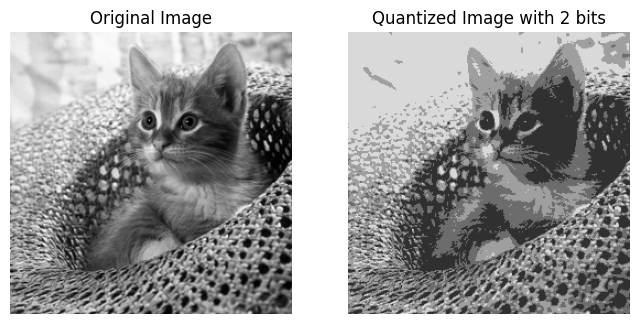

In [29]:
# Load image and quantize
img = cv2.imread('assets/cat.png', cv2.IMREAD_GRAYSCALE)
b = 2 # num bits

quantized_img = quantize_image(img, b)

# Display the original and compressed images
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))

plt_imshow(axs[0], img, title = 'Original Image')
plt_imshow(axs[1], quantized_img, title=f'Quantized Image with {b} bits')




Compression

In [10]:
def compress_image(image, levels, bits_per_level):
    ''' input: image(np.ndarray), levels(int), bits_per_level(list) -- output: compressed_image(np.ndarray)'''

    # Generate the Laplacian pyramid of the input image
    quantized_pyramid = build_laplacian_pyramid(image, levels)

    # Compress pyramid levels by quantizing them based on bits_per_level
    for i in range(levels):
      quantized_pyramid[i] = quantize_image(quantized_pyramid[i], bits_per_level[i])

    # Reconstruct new image from the compressed pyramid
    compressed_image = reconstruct_from_laplacian_pyramid(quantized_pyramid)

    return compressed_image


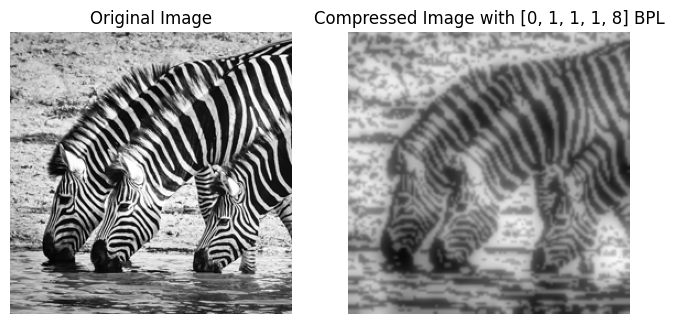

In [11]:
# Load image
original_image = cv2.imread('assets/zebra.png', cv2.IMREAD_GRAYSCALE)

# Specify the number of levels in the Laplacian pyramid
levels = 5

# Specify the number of bits to use for quantizing each level of the pyramid

bits_per_level = [0,1,1,1,8]

assert max(bits_per_level[:-1]) < 8 # Make sure less than 8 bits for quantization in every layer besides final layer
assert len(bits_per_level) == levels and bits_per_level[-1] == 8 # Make sure final level uses 8 bits (remains unchanged)

# Compress the input image by generating its Laplacian pyramid, compressing some levels by quantizing them,
# and then reconstructing a new image from the compressed pyramid
compressed_image = compress_image(original_image, levels, bits_per_level)



# Display the original and compressed images
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))

plt_imshow(axs[0], original_image, title = 'Original Image')
plt_imshow(axs[1], compressed_image, title=f'Compressed Image with {bits_per_level} BPL')


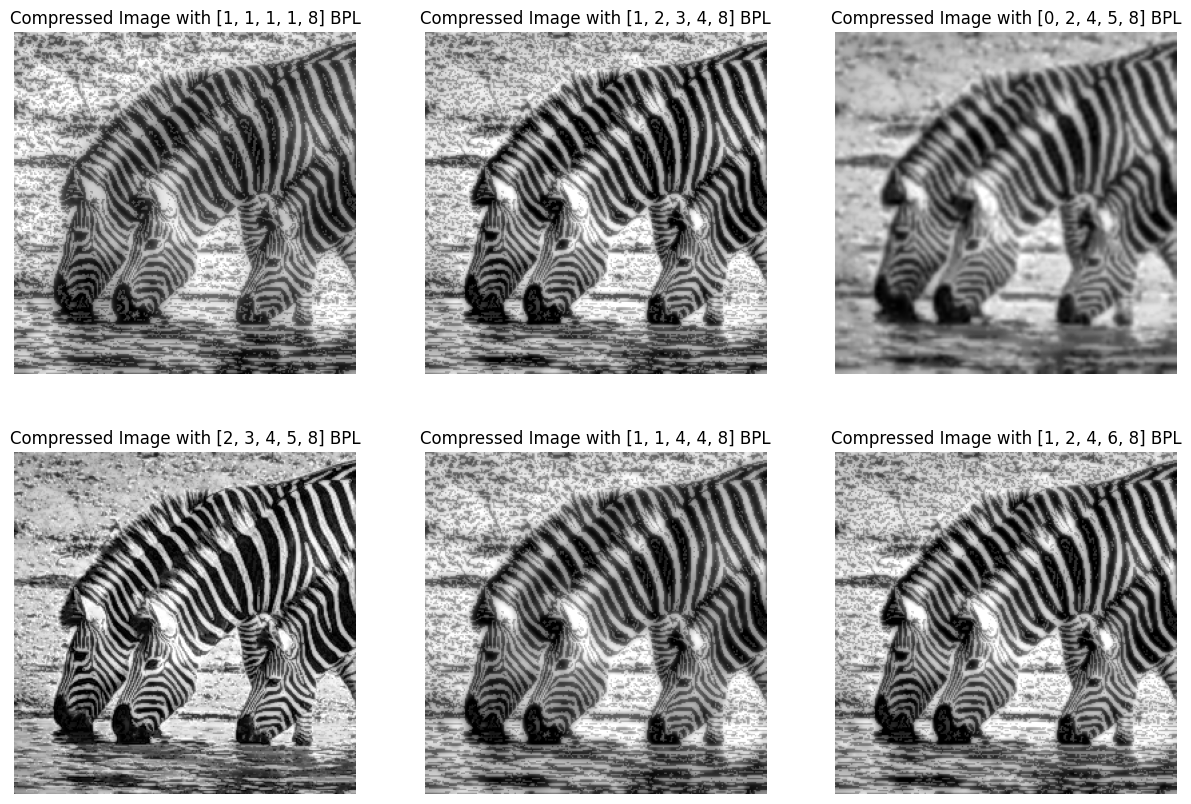

In [18]:
### CODE TO COMPARE DIFFERENT VALUES FOR COMPRESSION

# Load image
original_image = cv2.imread('assets/zebra.png', cv2.IMREAD_GRAYSCALE)

# Specify the number of levels in the Laplacian pyramid
levels = 5


# Display the original and compressed images
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))


bits_per_level = [1,1,1,1,8]
compressed_image = compress_image(original_image, levels, bits_per_level)
plt_imshow(axs[0,0], compressed_image, title=f'Compressed Image with {bits_per_level} BPL')

bits_per_level = [1,2,3,4,8]
compressed_image = compress_image(original_image, levels, bits_per_level)
plt_imshow(axs[0,1], compressed_image, title=f'Compressed Image with {bits_per_level} BPL')

bits_per_level = [0,2,4,5,8]
compressed_image = compress_image(original_image, levels, bits_per_level)
plt_imshow(axs[0,2], compressed_image, title=f'Compressed Image with {bits_per_level} BPL')

bits_per_level = [2,3,4,5,8]
compressed_image = compress_image(original_image, levels, bits_per_level)
plt_imshow(axs[1,0], compressed_image, title=f'Compressed Image with {bits_per_level} BPL')

bits_per_level = [1,1,4,4,8]
compressed_image = compress_image(original_image, levels, bits_per_level)
plt_imshow(axs[1,1], compressed_image, title=f'Compressed Image with {bits_per_level} BPL')

bits_per_level = [1,2,4,6,8]
compressed_image = compress_image(original_image, levels, bits_per_level)
plt_imshow(axs[1,2], compressed_image, title=f'Compressed Image with {bits_per_level} BPL')


### 3. Evaluation in the frequency domain

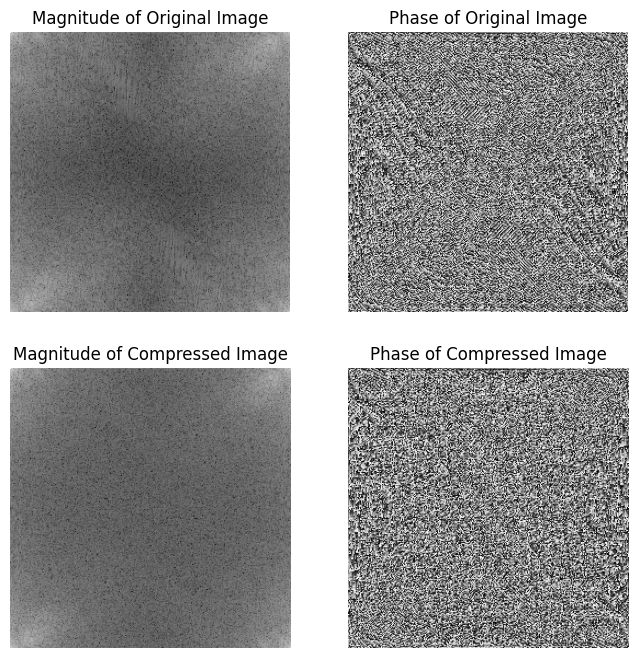

In [26]:
# Load image
original_image = cv2.imread('assets/zebra.png', cv2.IMREAD_GRAYSCALE)

# Specify the number of levels in the Laplacian pyramid
levels= 5

# Specify the number of bits to use for quantizing each level of the pyramid
bits_per_level = [1,2,3,4,8]

# Compress Image
compressed_image = compress_image(original_image, levels, bits_per_level)

# Transform both images into Frequency domain
fft1 = np.fft.fft2(original_image)
fft2 = np.fft.fft2(compressed_image)

# Compute the magnitude and phase of the FFT of both images
magnitude1 = np.abs(fft1)
magnitude2 = np.abs(fft2)
phase1 = np.angle(fft1)
phase2 = np.angle(fft2)

# Visualize the magnitude and phase of the FFT of both images
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

axs[0, 0].imshow(np.log(magnitude1), cmap='gray')
axs[0, 0].set_title('Magnitude of Original Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(phase1, cmap='gray')
axs[0, 1].set_title('Phase of Original Image')
axs[0, 1].axis('off')

axs[1, 0].imshow(np.log(magnitude2), cmap='gray')
axs[1, 0].set_title('Magnitude of Compressed Image')
axs[1, 0].axis('off')

axs[1, 1].imshow(phase2, cmap='gray')
axs[1, 1].set_title('Phase of Compressed Image')
axs[1, 1].axis('off');


# # Compute the difference in magnitude and phase between the two images
# magnitude_difference = np.abs(magnitude1 - magnitude2)
# phase_difference = np.abs(phase1 - phase2)
# # Visualize the difference in magnitude and phase between the two images
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(np.log(magnitude_difference), cmap='gray')
# axs[0].set_title('Difference in Magnitude')
# axs[1].imshow(phase_difference, cmap='gray')
# axs[1].set_title('Difference in Phase')